# Model trained using 300-dimensional pretrained FastText English word vectors released by [Facebook](https://www.kaggle.com/yekenot/fasttext-crawl-300d-2m).

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec
/kaggle/input/movie-review-sentiment-analysis-kernels-only/sampleSubmission.csv
/kaggle/input/movie-review-sentiment-analysis-kernels-only/test.tsv.zip
/kaggle/input/movie-review-sentiment-analysis-kernels-only/train.tsv.zip


In [2]:
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Embedding
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
#to print very long sentences in pandas df
pd.set_option('display.max_colwidth', -1)

In [4]:
!unzip  ../input/movie-review-sentiment-analysis-kernels-only/test.tsv.zip
!unzip  ../input/movie-review-sentiment-analysis-kernels-only/train.tsv.zip

Archive:  ../input/movie-review-sentiment-analysis-kernels-only/test.tsv.zip
  inflating: test.tsv                
Archive:  ../input/movie-review-sentiment-analysis-kernels-only/train.tsv.zip
  inflating: train.tsv               


In [5]:
train = pd.read_csv('/kaggle/working/train.tsv',sep = '\t')
test = pd.read_csv('/kaggle/working/test.tsv',sep = '\t')


In [6]:
sample_submsission =  pd.read_csv('/kaggle/input/movie-review-sentiment-analysis-kernels-only/sampleSubmission.csv')

In [7]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [8]:
to_remove = []
for i,row in train.iterrows():
    if(len(row['Phrase'].split())== 0):
        to_remove.append(i)
print(len(to_remove))
train.drop(to_remove,inplace = True)

1


In [9]:
tokenizer = Tokenizer()

In [10]:
full_text = list(test['Phrase'].values) + list(train['Phrase'].values)

In [11]:
tokenizer.fit_on_texts(full_text)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(train['Phrase'],train['Sentiment'],test_size = .1)

In [13]:
print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)

(140453,) (140453,)
(15606,) (15606,)


In [14]:
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(test['Phrase'])

In [15]:
max_len = 40
#using default pre padding. if phrase length is more than 40, it is truncated from starting.
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_valid = sequence.pad_sequences(X_valid, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print(X_train.shape,X_valid.shape,X_test.shape)

(140453, 40) (15606, 40) (66292, 40)


In [16]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
print(y_train.shape,y_valid.shape)

(140453, 5) (15606, 5)


In [17]:
embedding_path = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"

In [18]:
max_features = 17780 #using all unique words
embedding_dim = 300
num_classes = 5
batch_size = 64

In [19]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

word_index = tokenizer.word_index
nb_words = len(word_index)
embedding_matrix = np.zeros((nb_words + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [20]:
#callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
reduce_lr =  ReduceLROnPlateau(monitor='val_loss',verbose=1, factor=.1,patience=5)
checkpointer = ModelCheckpoint('model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [21]:
model = Sequential()
model.add(Embedding(max_features + 1, embedding_dim, input_length= max_len, mask_zero = True, weights = [embedding_matrix], trainable = False)) #using pre-trained embeddings
model.add(LSTM(100,dropout=0.6, recurrent_dropout=0.5,return_sequences=True))                         #returning full sequence for next layer, also using recurrent output
model.add(LSTM(64,dropout=0.6, recurrent_dropout=0.5,return_sequences=False))                         #returning only last output.  
model.add(Dense(num_classes,activation='softmax'))                                                    #final output

model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 300)           5334300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 100)           160400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 5,537,265
Trainable params: 202,965
Non-trainable params: 5,334,300
_________________________________________________________________


In [22]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid),epochs=50, batch_size=batch_size, verbose=1,callbacks = [es,reduce_lr,checkpointer])

Train on 140453 samples, validate on 15606 samples
Epoch 1/50
140453/140453 [==============================] - 247s 2ms/step - loss: 1.0331 - accuracy: 0.5730 - val_loss: 0.9371 - val_accuracy: 0.5992

Epoch 00001: val_loss improved from inf to 0.93712, saving model to model.hdf5
Epoch 2/50
140453/140453 [==============================] - 245s 2ms/step - loss: 0.9989 - accuracy: 0.5847 - val_loss: 0.8973 - val_accuracy: 0.6238

Epoch 00002: val_loss improved from 0.93712 to 0.89731, saving model to model.hdf5
Epoch 3/50
140453/140453 [==============================] - 244s 2ms/step - loss: 0.9940 - accuracy: 0.5891 - val_loss: 0.8925 - val_accuracy: 0.6273

Epoch 00003: val_loss improved from 0.89731 to 0.89253, saving model to model.hdf5
Epoch 4/50
140453/140453 [==============================] - 245s 2ms/step - loss: 0.9953 - accuracy: 0.5865 - val_loss: 0.8916 - val_accuracy: 0.6273

Epoch 00004: val_loss improved from 0.89253 to 0.89159, saving model to model.hdf5
Epoch 5/50
140453

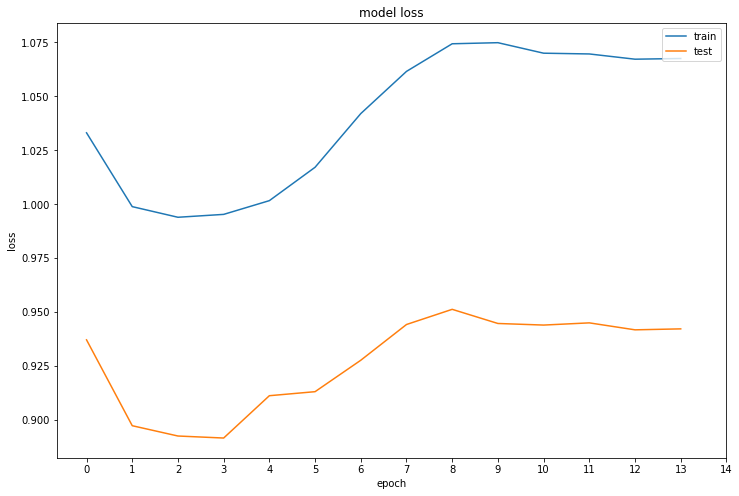

In [23]:
#let's plot losses

history = model.history.history
# list all data in history
#print(history.keys())
# summarize history for accuracy
plt.figure(figsize = (12,8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])

ticks = list(range(len(history['loss'])+1)) # we need integers in x axis (epochs)
plt.xticks(ticks)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [24]:
model.load_weights('model.hdf5')

In [25]:
predictions = model.predict(X_test)

In [26]:
y_test = predictions.argmax(axis = 1) 
y_test.shape

(66292,)

In [27]:
sample_submsission.Sentiment = y_test

In [28]:
sample_submsission.to_csv('submission.csv',index=False)